In [27]:
#Import necessary libraries
import os
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
root_dir = "/content/drive/MyDrive/weather dataset"

for dirpath, dirnames, filenames in os.walk(root_dir):
    print(f"Directory: {dirpath}")
    print(f"Number of images: {len(filenames)}")
    print()


Directory: /content/drive/MyDrive/weather dataset
Number of images: 0

Directory: /content/drive/MyDrive/weather dataset/train
Number of images: 0

Directory: /content/drive/MyDrive/weather dataset/train/cloud
Number of images: 207

Directory: /content/drive/MyDrive/weather dataset/train/shine
Number of images: 189

Directory: /content/drive/MyDrive/weather dataset/train/rain
Number of images: 152

Directory: /content/drive/MyDrive/weather dataset/train/sunrise
Number of images: 243

Directory: /content/drive/MyDrive/weather dataset/test
Number of images: 0

Directory: /content/drive/MyDrive/weather dataset/test/sunrise
Number of images: 61

Directory: /content/drive/MyDrive/weather dataset/test/shine
Number of images: 29

Directory: /content/drive/MyDrive/weather dataset/test/cloud
Number of images: 35

Directory: /content/drive/MyDrive/weather dataset/test/rain
Number of images: 30

Directory: /content/drive/MyDrive/weather dataset/validation
Number of images: 0

Directory: /content/

In [7]:
def retrieve_labels(train_dir, test_dir, val_dir):
  # Retrieve labels from training directory
  train_labels = os.listdir(train_dir)
  print(f"Training labels: {train_labels}")
  print(f"Number of training labels: {len(train_labels)}")
  print()

  # Retrieve labels from test directory
  test_labels = os.listdir(test_dir)
  print(f"Test labels: {test_labels}")
  print(f"Number of test labels: {len(test_labels)}")
  print()

  # Retrieve labels from validation directory
  val_labels = os.listdir(val_dir)
  print(f"Validation labels: {val_labels}")
  print(f"Number of validation labels: {len(val_labels)}")
  print()


In [8]:
train_dir = "/content/drive/MyDrive/weather dataset/train"
test_dir = "/content/drive/MyDrive/weather dataset/test"
val_dir = "/content/drive/MyDrive/weather dataset/validation"
retrieve_labels(train_dir, test_dir, val_dir)

Training labels: ['cloud', 'shine', 'rain', 'sunrise']
Number of training labels: 4

Test labels: ['sunrise', 'shine', 'cloud', 'rain']
Number of test labels: 4

Validation labels: ['shine', 'sunrise', 'cloud', 'rain']
Number of validation labels: 4



In [9]:
def view_random_images(target_dir, num_images):
  """
  View num_images random images from the subdirectories of target_dir as a subplot.
  """
  # Get list of subdirectories
  subdirs = [d for d in os.listdir(target_dir) if os.path.isdir(os.path.join(target_dir, d))]

  # Select num_images random subdirectories
  random.shuffle(subdirs)
  selected_subdirs = subdirs[:num_images]

  # Create a subplot
  fig, axes = plt.subplots(1, num_images, figsize=(15,9))
  for i, subdir in enumerate(selected_subdirs):
      # Get list of images in subdirectory
      image_paths = [f for f in os.listdir(os.path.join(target_dir, subdir))]
      # Select a random image
      image_path = random.choice(image_paths)
      # Load image
      image = plt.imread(os.path.join(target_dir, subdir, image_path))
      # Display image in subplot
      axes[i].imshow(image)
      axes[i].axis("off")
      axes[i].set_title(subdir)
  print(f"Shape of image: {image.shape}")    #width, height, colour channels
  plt.show()



In [10]:
def plot_loss_accuracy(history_1):
  # Extract the loss and accuracy history for both training and validation data
  loss = history_1.history['loss']
  val_loss = history_1.history['val_loss']
  acc = history_1.history['accuracy']
  val_acc = history_1.history['val_accuracy']

  # Create subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))

  # Plot the loss history
  ax1.plot(loss, label='Training loss')
  ax1.plot(val_loss, label='Validation loss')
  ax1.set_title('Loss history')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # Plot the accuracy history
  ax2.plot(acc, label='Training accuracy')
  ax2.plot(val_acc, label='Validation accuracy')
  ax2.set_title('Accuracy history')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.show()


Shape of image: (174, 261, 3)


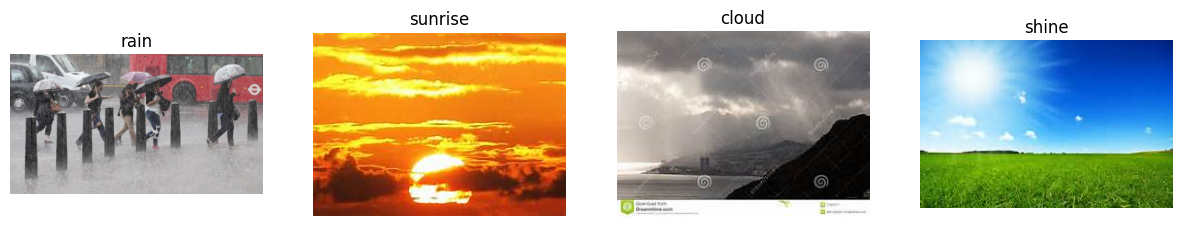

In [11]:
view_random_images(target_dir="/content/drive/MyDrive/weather dataset/test/", num_images=4)

In [12]:
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "/content/drive/MyDrive/weather dataset/train/"
val_dir = "/content/drive/MyDrive/weather dataset/validation/"
test_dir = "/content/drive/MyDrive/weather dataset/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64, # number of images to process at a time
                                               target_size=(224,224), # convert all images to be 224 x 224
                                               class_mode="categorical")

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224,224),
                                               class_mode="categorical")
test_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224,224),
                                               class_mode="categorical")


Found 791 images belonging to 4 classes.
Found 179 images belonging to 4 classes.
Found 155 images belonging to 4 classes.


In [13]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=16,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), #(height, width, colour channels)
tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1050, activation="relu"),
  tf.keras.layers.Dense(4, activation="softmax") # multiclass activation output
])

# Compile the model
model_1.compile(loss="CategoricalCrossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=10,
                        validation_data=valid_data,
                        )

Epoch 1/10
13/13 [==============================] - 227s 18s/step - loss: 37.4265 - accuracy: 0.5057 - val_loss: 6.5223 - val_accuracy: 0.6089
Epoch 2/10
13/13 [==============================] - 91s 7s/step - loss: 4.0301 - accuracy: 0.7585 - val_loss: 1.2760 - val_accuracy: 0.8715
Epoch 3/10
13/13 [==============================] - 92s 7s/step - loss: 1.3843 - accuracy: 0.8660 - val_loss: 0.7729 - val_accuracy: 0.8603
Epoch 4/10
13/13 [==============================] - 83s 6s/step - loss: 0.5759 - accuracy: 0.8976 - val_loss: 0.6303 - val_accuracy: 0.8883
Epoch 5/10
13/13 [==============================] - 85s 6s/step - loss: 0.3402 - accuracy: 0.9317 - val_loss: 0.7613 - val_accuracy: 0.8715
Epoch 6/10
13/13 [==============================] - 85s 6s/step - loss: 0.2007 - accuracy: 0.9558 - val_loss: 0.8052 - val_accuracy: 0.8715
Epoch 7/10
13/13 [==============================] - 90s 7s/step - loss: 0.1230 - accuracy: 0.9633 - val_loss: 0.5689 - val_accuracy: 0.8659
Epoch 8/10
13/13 

In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 197136)            0         
                                                                 
 dense (Dense)               (None, 1050)              206993850 
                                                                 
 dense_1 (Dense)             (None, 4)                 4204      
                                                                 
Total params: 206998502 (789.64 MB)
Trainable params: 206998502 (789.64 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [15]:
model_1.evaluate(test_data)

3/3 [==============================] - 26s 12s/step - loss: 0.5039 - accuracy: 0.9032


[0.5039120316505432, 0.9032257795333862]

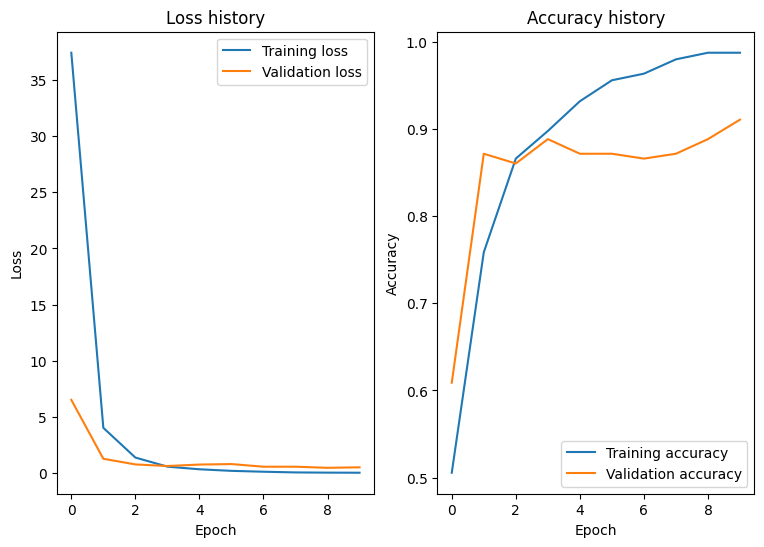

In [16]:
# Lets plot the training and validation loss and accuruacy
plot_loss_accuracy(history_1)

#Early stopping

In [17]:
#Build the model
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=16,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), #(height, width, colour channels)
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1050, activation="relu"),
  tf.keras.layers.Dense(4, activation="softmax")
])

# Compile the model
model_2.compile(loss="CategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Add an early stopping callback
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]
history_2 = model_2.fit(train_data,
epochs=50,
validation_data=valid_data,
callbacks=[callbacks]
)



Epoch 1/50
13/13 [==============================] - 60s 4s/step - loss: 1.9406 - accuracy: 0.5234 - val_loss: 0.6637 - val_accuracy: 0.7430
Epoch 2/50
13/13 [==============================] - 58s 4s/step - loss: 0.6909 - accuracy: 0.7155 - val_loss: 0.5053 - val_accuracy: 0.8101
Epoch 3/50
13/13 [==============================] - 58s 4s/step - loss: 0.5248 - accuracy: 0.8078 - val_loss: 0.4298 - val_accuracy: 0.8268
Epoch 4/50
13/13 [==============================] - 62s 5s/step - loss: 0.3819 - accuracy: 0.8597 - val_loss: 0.5010 - val_accuracy: 0.8156
Epoch 5/50
13/13 [==============================] - 59s 5s/step - loss: 0.2906 - accuracy: 0.8875 - val_loss: 0.2748 - val_accuracy: 0.9106
Epoch 6/50
13/13 [==============================] - 66s 5s/step - loss: 0.2166 - accuracy: 0.9229 - val_loss: 0.2949 - val_accuracy: 0.8939
Epoch 7/50
13/13 [==============================] - 61s 5s/step - loss: 0.2188 - accuracy: 0.9216 - val_loss: 0.2462 - val_accuracy: 0.9106
Epoch 8/50
13/13 [==

In [18]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 26, 26, 64)       

#Model simplification

In [19]:
#Build the model
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=16,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), #(height, width, colour channels)
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(500, activation="relu"),
  tf.keras.layers.Dense(4, activation="softmax")
])

# Compile the model
model_3.compile(loss="CategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Add an early stopping callback
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]
history_3 = model_3.fit(train_data,
epochs=50,
validation_data=valid_data,
callbacks=[callbacks]
)



Epoch 1/50
13/13 [==============================] - 52s 4s/step - loss: 1.4497 - accuracy: 0.5272 - val_loss: 0.8447 - val_accuracy: 0.5754
Epoch 2/50
13/13 [==============================] - 52s 4s/step - loss: 0.7070 - accuracy: 0.7408 - val_loss: 0.4174 - val_accuracy: 0.8771
Epoch 3/50
13/13 [==============================] - 54s 4s/step - loss: 0.4838 - accuracy: 0.8420 - val_loss: 0.3289 - val_accuracy: 0.8939
Epoch 4/50
13/13 [==============================] - 52s 4s/step - loss: 0.3956 - accuracy: 0.8635 - val_loss: 0.3355 - val_accuracy: 0.8883
Epoch 5/50
13/13 [==============================] - 60s 5s/step - loss: 0.3016 - accuracy: 0.8976 - val_loss: 0.2508 - val_accuracy: 0.9162
Epoch 6/50
13/13 [==============================] - 53s 4s/step - loss: 0.2243 - accuracy: 0.9140 - val_loss: 0.4359 - val_accuracy: 0.8436
Epoch 7/50
13/13 [==============================] - 54s 4s/step - loss: 0.2693 - accuracy: 0.8976 - val_loss: 0.2087 - val_accuracy: 0.9385
Epoch 8/50
13/13 [==

#L1 and L2 regularization

### L2

In [24]:
model_4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=16,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), #(height, width, colour channels)
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1050, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
  tf.keras.layers.Dense(4, activation="softmax")])

# Compile the model with l2
model_4.compile(loss="CategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
# Add an early stopping callback
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]
history_4 = model_4.fit(train_data,
                        epochs=50,
                        validation_data=valid_data,
                        callbacks=[callbacks]
                        )



Epoch 1/50
13/13 [==============================] - 69s 5s/step - loss: 10.1835 - accuracy: 0.4855 - val_loss: 3.9638 - val_accuracy: 0.7542
Epoch 2/50
13/13 [==============================] - 62s 5s/step - loss: 3.2566 - accuracy: 0.7547 - val_loss: 2.0574 - val_accuracy: 0.8603
Epoch 3/50
13/13 [==============================] - 68s 5s/step - loss: 1.6289 - accuracy: 0.8268 - val_loss: 1.0671 - val_accuracy: 0.9330
Epoch 4/50
13/13 [==============================] - 62s 5s/step - loss: 1.0478 - accuracy: 0.8167 - val_loss: 0.7210 - val_accuracy: 0.9162
Epoch 5/50
13/13 [==============================] - 60s 4s/step - loss: 0.8118 - accuracy: 0.8496 - val_loss: 0.8664 - val_accuracy: 0.7933
Epoch 6/50
13/13 [==============================] - 62s 5s/step - loss: 0.7245 - accuracy: 0.8407 - val_loss: 0.5299 - val_accuracy: 0.9385
Epoch 7/50
13/13 [==============================] - 65s 5s/step - loss: 0.6747 - accuracy: 0.8470 - val_loss: 0.4938 - val_accuracy: 0.9385
Epoch 8/50
13/13 [=

### L1

In [28]:
model_5 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=16,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), #(height, width, colour channels)
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1050, activation="relu", kernel_regularizer=regularizers.l1(0.01)),
  tf.keras.layers.Dense(4, activation="softmax")
])

# Compile the model with l1
model_5.compile(loss="CategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_5 =model_5.fit(train_data,
          epochs=20,
          validation_data=valid_data,
          callbacks=[callbacks])


Epoch 1/20
13/13 [==============================] - 92s 7s/step - loss: 1426.5197 - accuracy: 0.4437 - val_loss: 657.4294 - val_accuracy: 0.6425
Epoch 2/20
13/13 [==============================] - 85s 7s/step - loss: 417.0652 - accuracy: 0.6308 - val_loss: 263.5043 - val_accuracy: 0.7933
Epoch 3/20
13/13 [==============================] - 77s 6s/step - loss: 219.0240 - accuracy: 0.5171 - val_loss: 172.9654 - val_accuracy: 0.6648
Epoch 4/20
13/13 [==============================] - 79s 6s/step - loss: 154.8515 - accuracy: 0.5777 - val_loss: 138.9196 - val_accuracy: 0.6089
Epoch 5/20
13/13 [==============================] - 81s 6s/step - loss: 134.8920 - accuracy: 0.5765 - val_loss: 129.8365 - val_accuracy: 0.7263


#Drop Out

In [29]:
model_6 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=16,
                           kernel_size=3, # can also be (3, 3)
                           activation="relu",
                           input_shape=(224, 224, 3)), #(height, width, colour channels)
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(32, 3, activation="relu"),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(64, 3, activation="relu"),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1050, activation="relu"),
      tf.keras.layers.Dropout(0.6), # added dropout layer
      tf.keras.layers.Dense(4, activation="softmax")
    ])

# Compile the model
model_6.compile(loss="CategoricalCrossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

    # Fit the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)
history_6 = model_6.fit(train_data,
                        epochs=10,
                        validation_data=valid_data, callbacks=[callbacks])

Epoch 1/10
13/13 [==============================] - 60s 4s/step - loss: 1.7501 - accuracy: 0.4994 - val_loss: 0.7217 - val_accuracy: 0.6536
Epoch 2/10
13/13 [==============================] - 62s 5s/step - loss: 0.6523 - accuracy: 0.7535 - val_loss: 0.3218 - val_accuracy: 0.9050
Epoch 3/10
13/13 [==============================] - 60s 5s/step - loss: 0.4636 - accuracy: 0.8483 - val_loss: 0.3640 - val_accuracy: 0.9050
Epoch 4/10
13/13 [==============================] - 58s 4s/step - loss: 0.3670 - accuracy: 0.8698 - val_loss: 0.2510 - val_accuracy: 0.9218
Epoch 5/10
13/13 [==============================] - 65s 5s/step - loss: 0.2827 - accuracy: 0.8963 - val_loss: 0.5474 - val_accuracy: 0.8268
Epoch 6/10
13/13 [==============================] - 57s 4s/step - loss: 0.2984 - accuracy: 0.8887 - val_loss: 0.2199 - val_accuracy: 0.8827
Epoch 7/10
13/13 [==============================] - 61s 5s/step - loss: 0.2782 - accuracy: 0.9077 - val_loss: 0.2406 - val_accuracy: 0.9330
Epoch 8/10
13/13 [==

#Adjusting the learning rate

In [30]:
model_7 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=16,
                           kernel_size=3, # can also be (3, 3)
                           activation="relu",
                           input_shape=(224, 224, 3)), #(height, width, colour channels)
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(32, 3, activation="relu"),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(64, 3, activation="relu"),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1050, activation="relu"),
      tf.keras.layers.Dropout(0.6), # added dropout layer
      tf.keras.layers.Dense(4, activation="softmax")
    ])

# Compile the model
model_7.compile(loss="CategoricalCrossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy"])

    # Fit the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)
history_7 = model_7.fit(train_data,
                        epochs=10,
                        validation_data=valid_data, callbacks=[callbacks])

Epoch 1/10
13/13 [==============================] - 62s 5s/step - loss: 1.3242 - accuracy: 0.3869 - val_loss: 1.0841 - val_accuracy: 0.4358
Epoch 2/10
13/13 [==============================] - 58s 4s/step - loss: 0.9503 - accuracy: 0.5917 - val_loss: 0.7617 - val_accuracy: 0.7542
Epoch 3/10
13/13 [==============================] - 63s 5s/step - loss: 0.7407 - accuracy: 0.7042 - val_loss: 0.5634 - val_accuracy: 0.8659
Epoch 4/10
13/13 [==============================] - 61s 5s/step - loss: 0.6095 - accuracy: 0.7813 - val_loss: 0.4728 - val_accuracy: 0.8603
Epoch 5/10
13/13 [==============================] - 58s 4s/step - loss: 0.5327 - accuracy: 0.7889 - val_loss: 0.3856 - val_accuracy: 0.8939
Epoch 6/10
13/13 [==============================] - 60s 4s/step - loss: 0.4510 - accuracy: 0.8306 - val_loss: 0.4229 - val_accuracy: 0.8492
Epoch 7/10
13/13 [==============================] - 59s 4s/step - loss: 0.4032 - accuracy: 0.8635 - val_loss: 0.3378 - val_accuracy: 0.8994
Epoch 8/10
13/13 [==

#Data Augmentation

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=25,
 width_shift_range=0.3,
 height_shift_range=0.3,
 horizontal_flip=True, )
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "/content/drive/MyDrive/weather dataset/train/"
val_dir = "/content/drive/MyDrive/weather dataset/validation/"
test_dir = "/content/drive/MyDrive/weather dataset/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224), # convert all images to be 224 x 224
                                               class_mode="categorical")

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               target_size=(224,224),
                                               class_mode="categorical")
test_data = valid_datagen.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               class_mode="categorical",)


Found 791 images belonging to 4 classes.
Found 179 images belonging to 4 classes.
Found 155 images belonging to 4 classes.


In [33]:
model_8 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=16,
                           kernel_size=3, # can also be (3, 3)
                           activation="relu",
                           input_shape=(224, 224, 3)), #(height, width, colour channels)
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(32, 3, activation="relu"),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(64, 3, activation="relu"),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1050, activation="relu"),
      #tf.keras.layers.Dropout(0.6), # added dropout layer
      tf.keras.layers.Dense(4, activation="softmax")
    ])

# Compile the model
model_8.compile(loss="CategoricalCrossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

    # Fit the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)
history_8 = model_8.fit(train_data,
                        epochs=10,
                        validation_data=valid_data, callbacks=[callbacks])



Epoch 1/10
25/25 [==============================] - 85s 3s/step - loss: 1.3706 - accuracy: 0.5272 - val_loss: 0.6665 - val_accuracy: 0.6145
Epoch 2/10
25/25 [==============================] - 77s 3s/step - loss: 0.7276 - accuracy: 0.6991 - val_loss: 0.4370 - val_accuracy: 0.8380
Epoch 3/10
25/25 [==============================] - 77s 3s/step - loss: 0.5455 - accuracy: 0.7699 - val_loss: 0.3499 - val_accuracy: 0.8715
Epoch 4/10
25/25 [==============================] - 76s 3s/step - loss: 0.4481 - accuracy: 0.8319 - val_loss: 0.4197 - val_accuracy: 0.8492
Epoch 5/10
25/25 [==============================] - 77s 3s/step - loss: 0.4910 - accuracy: 0.8293 - val_loss: 0.2656 - val_accuracy: 0.8827
Epoch 6/10
25/25 [==============================] - 76s 3s/step - loss: 0.4172 - accuracy: 0.8458 - val_loss: 0.4218 - val_accuracy: 0.8324
Epoch 7/10
25/25 [==============================] - 77s 3s/step - loss: 0.3890 - accuracy: 0.8470 - val_loss: 0.3669 - val_accuracy: 0.8268
Epoch 8/10
25/25 [==

#Model evaluation

In [34]:
def evaluate_models(models, model_names,test_data):

    # Initialize lists for the results
    losses = []
    accuracies = []

    # Iterate over the models
    for model in models:
        # Evaluate the model
        loss, accuracy = model.evaluate(test_data)
        losses.append(loss)
        accuracies.append(accuracy)
       # Convert the results to percentages
    losses = [round(loss * 100, 2) for loss in losses]
    accuracies = [round(accuracy * 100, 2) for accuracy in accuracies]

    # Create a dataframe with the results
    results = pd.DataFrame({"Model": model_names,
                            "Loss": losses,
                            "Accuracy": accuracies})

    return results


In [35]:
# Define the models and model names
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]
model_names = ["model 1", "model 2", "model 3", "model 4", "model 5", "model 6", "model 7", "model 8"]

# Evaluate the models
results = evaluate_models(models, model_names,test_data)

# Display the results
results
results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True).head()

5/5 [==============================] - 4s 664ms/step - loss: 0.2854 - accuracy: 0.8774


,Model,Loss,Accuracy
0,model 4,48.55,94.19
1,model 7,25.97,93.55
2,model 2,31.36,92.26
3,model 3,32.20,90.97
4,model 6,28.53,90.97


In [39]:
#lets save our best model
model_4.save("/content/drive/MyDrive/weather dataset/model.h5")
# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/weather dataset/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Note
This is the new method recommended by TensorFlow when saving models

In [40]:
model_4.save("/content/drive/MyDrive/weather dataset/model.keras")
# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/weather dataset/model.keras")

